<a href="https://colab.research.google.com/github/SamuelTelesSilva/toxic_comment_detection/blob/main/notebooks/classifica%C3%A7%C3%A3o_de_texto_Multilabel/spacy_detectando_comentarios_multlabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Instalação

In [ ]:
!pip install tensorflow
!pip install nltk
!pip install -U spacy
#[Ctrl+M] or `Restart runtime` from menu bar
!python -m spacy download pt_core_news_md
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.4 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras import optimizers


##Fazendo alterações no dataset

In [ ]:
PATH = "/content/drive/MyDrive/Pós-Graduação/Projeto de IA com Aprendizagem de Máquina/dataset/told_df_6.csv"

In [ ]:
told_br = pd.read_csv(PATH)

In [ ]:
#removendo a coluna unnamed
told_br.drop(told_br.columns[told_br.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [ ]:
told_br.head()

,text,text_norm,homophobia,obscene,insult,racism,misogyny,xenophobia,label,toxic
0,Meu nivel de amizade com isis é ela ter meu in...,nível amizade isis ter insta ter penso manda m...,0.0,0.0,2.0,0.0,0.0,0.0,Insult,1
1,"rt @user @user o cara adultera dados, que fora...",cara adultera dados desmascarados ainda quer f...,0.0,0.0,1.0,0.0,0.0,0.0,Insult,1
2,@user @user @user o cara só é simplesmente o m...,cara simplesmente maior vencedor história fute...,0.0,2.0,1.0,0.0,0.0,0.0,Obscene,1
3,eu to chorando vei vsf e eu nem staneio izone ...,to chorando velho vá foder enalteço ozone nada,0.0,1.0,0.0,0.0,0.0,0.0,Obscene,1
4,Eleitor do Bolsonaro é tão ignorante q não per...,eleitor bolsonaro tão ignorante percebeu frase...,0.0,1.0,2.0,0.0,0.0,0.0,Insult,1


In [ ]:
#alterando o tipo da coluna text_norm
told_br['text_norm'] = told_br['text_norm'].astype(str)

In [ ]:
told_br.shape

(21000, 10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


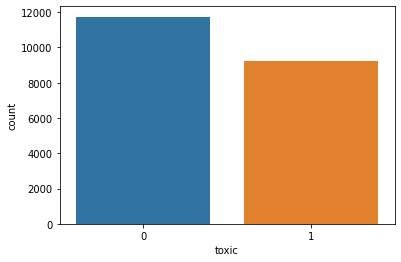

In [ ]:
sns.countplot(told_br['toxic']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


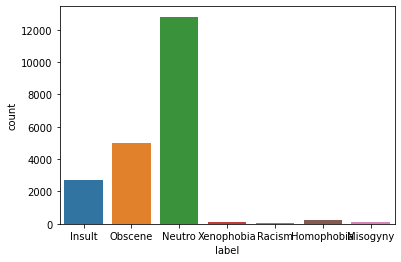

In [ ]:
sns.countplot(told_br['label']);

In [ ]:
np.unique(told_br['label'], return_counts=True)

(array(['Homophobia', 'Insult', 'Misogyny', 'Neutro', 'Obscene', 'Racism',
        'Xenophobia'], dtype=object),
 array([  207,  2730,    95, 12812,  5017,    54,    85]))

##Embedding

**Embedding words**

- 1. word -> word-ID : word-ID para cada palavra com o Keras Tokenizer. O Tokenizer contém todo o vocabulário e mapeia cada palavra do vocabulário para um ID, que é um número inteiro.

- 2. word-ID -> word vector: Um word-ID é um número inteiro e, portanto, pode ser usado como um índice para as linhas da tabela de incorporação. Cada palavra-ID corresponde a uma linha e quando queremos obter o vetor de palavras de uma palavra, primeiro obtemos sua palavra-ID e, em seguida, fazemos uma pesquisa nas linhas da tabela de incorporação com esta palavra-ID.



O diagrama a seguir mostra como funciona a incorporação de palavras em vetores de palavras:

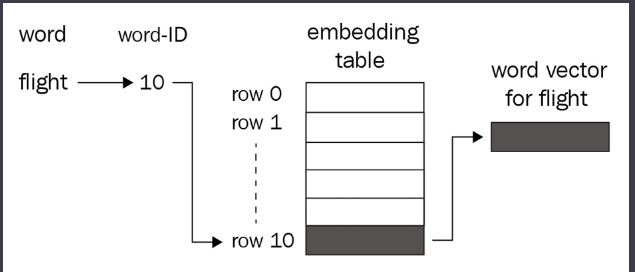

- Quebramos cada frase em palavras e construímos um vocabulário com o Tokenizer da Keras.

- O objeto Tokenizer continha um índice de palavras, que era um mapeamento palavra -> palavra-ID.

- Depois de obter o ID da palavra, poderíamos fazer uma pesquisa nas linhas da tabela de incorporação com este ID da palavra e obter um vetor de palavras.

In [ ]:
told_br

,text,text_norm,homophobia,obscene,insult,racism,misogyny,xenophobia,label,toxic
0,Meu nivel de amizade com isis é ela ter meu in...,nível amizade isis ter insta ter penso manda m...,0.0,0.0,2.0,0.0,0.0,0.0,Insult,1
1,"rt @user @user o cara adultera dados, que fora...",cara adultera dados desmascarados ainda quer f...,0.0,0.0,1.0,0.0,0.0,0.0,Insult,1
2,@user @user @user o cara só é simplesmente o m...,cara simplesmente maior vencedor história fute...,0.0,2.0,1.0,0.0,0.0,0.0,Obscene,1
3,eu to chorando vei vsf e eu nem staneio izone ...,to chorando velho vá foder enalteço ozone nada,0.0,1.0,0.0,0.0,0.0,0.0,Obscene,1
4,Eleitor do Bolsonaro é tão ignorante q não per...,eleitor bolsonaro tão ignorante percebeu frase...,0.0,1.0,2.0,0.0,0.0,0.0,Insult,1
...,...,...,...,...,...,...,...,...,...,...
20995,@user faz favor vai carai,faz favor vai caralho,0.0,0.0,0.0,0.0,0.0,0.0,Neutro,0
20996,só queria conhecer alguém que não conhece o he...,queria conhecer alguém conhece hetero taubaté ...,1.0,0.0,0.0,0.0,0.0,0.0,Homophobia,1
20997,"vcs militam na hora errada em cima de memes, p...",militam hora errada cima menes ninguém suporta...,0.0,0.0,0.0,0.0,0.0,0.0,Neutro,0
20998,@user porra any eu tava c dor de cabeca e fui ...,porra any tava dor cabeça comer,0.0,0.0,0.0,0.0,0.0,0.0,Neutro,0


In [ ]:
told_br['text_norm']

0        nível amizade isis ter insta ter penso manda m...
1        cara adultera dados desmascarados ainda quer f...
2        cara simplesmente maior vencedor história fute...
3           to chorando velho vá foder enalteço ozone nada
4        eleitor bolsonaro tão ignorante percebeu frase...
                               ...                        
20995                                faz favor vai caralho
20996    queria conhecer alguém conhece hetero taubaté ...
20997    militam hora errada cima menes ninguém suporta...
20998                      porra any tava dor cabeça comer
20999             saudades iasmin gótica demais puta pariu
Name: text_norm, Length: 21000, dtype: object

In [ ]:
#Um pipeline treinado em português
nlp = spacy.load("pt_core_news_md")

Observe que anexamos uma lista de palavras a train_examples, portanto, cada elemento dessa lista é uma lista de palavras. Em seguida, invocaremos o Tokenizer do Keras nesta lista de palavras para construir nosso vocabulário.

In [ ]:
train_examples = []
labels = []

for index, row in told_br.iterrows():
    text = row["text_norm"]
    rating = row["label"]
    labels.append(rating)
    tokens = [token.text for token in nlp(text)]
    train_examples.append(tokens)

Estamos prontos para ajustar o objeto Tokenizer em nossa lista de palavras. Primeiro, ajustaremos o Tokenizer, depois converteremos as palavras em seus IDs chamando text_to_sequences

In [ ]:
#Criamos um objeto tokenizer com o parâmetro lower=True , o que significa que o tokenizer deve diminuir todas as palavras enquanto cria o vocabulário.
tokenizer = Tokenizer(lower=True)
#Chamamos tokenizer.fit_on_texts nos dados para construir o vocabulário.
#fit_on_text funciona em uma sequência de palavras, a entrada deve ser sempre uma lista de palavras
tokenizer.fit_on_texts(train_examples)
#convertendo as palavras em seus IDs chamando text_to_sequences
sequences = tokenizer.texts_to_sequences(train_examples)

In [ ]:
#Avaliando
#Word_index é basicamente um dicionário onde as chaves são palavras de vocabulário e os valores são IDs de palavras.
tokenizer.word_index

{'puta': 1,
 'pra': 2,
 '`': 3,
 'caralho': 4,
 'pariu': 5,
 'porra': 6,
 'vai': 7,
 'cu': 8,
 'porque': 9,
 'ser': 10,
 'vou': 11,
 ' ': 12,
 'cara': 13,
 'gente': 14,
 'to': 15,
 'mano': 16,
 'hoje': 17,
 'nada': 18,
 'dia': 19,
 'tudo': 20,
 'fazer': 21,
 'agora': 22,
 'foder': 23,
 'ter': 24,
 'filho': 25,
 'ainda': 26,
 'todo': 27,
 'pau': 28,
 'aqui': 29,
 'merda': 30,
 'vida': 31,
 'casa': 32,
 'ver': 33,
 'bem': 34,
 'coisa': 35,
 'ai': 36,
 '  ': 37,
 'lixo': 38,
 'ficar': 39,
 'muita': 40,
 'mundo': 41,
 'aí': 42,
 'bom': 43,
 'pode': 44,
 'deus': 45,
 'queria': 46,
 'demais': 47,
 'amo': 48,
 'mim': 49,
 'quero': 50,
 'tão': 51,
 'nunca': 52,
 'sim': 53,
 'assim': 54,
 'feio': 55,
 'pessoa': 56,
 'faz': 57,
 'quer': 58,
 'fica': 59,
 'sei': 60,
 'sempre': 61,
 'ninguém': 62,
 'pessoas': 63,
 'tomar': 64,
 'feia': 65,
 'fala': 66,
 'alguém': 67,
 'tava': 68,
 'melhor': 69,
 'falar': 70,
 'mãe': 71,
 'acho': 72,
 'olha': 73,
 'amor': 74,
 'falando': 75,
 'pro': 76,
 'neo': 77,

In [ ]:
sequences

[[631, 421, 7410, 24, 762, 24, 763, 219, 482, 75, 1168, 75, 120, 762],
 [13, 10735, 764, 10736, 26, 58, 39, 174],
 [13, 506, 191, 5702, 254, 368, 95, 1872, 47, 448, 2813, 203],
 [15, 390, 122, 81, 23, 10737, 7411, 18],
 [5703,
  135,
  51,
  1540,
  5704,
  1279,
  1634,
  1394,
  1635,
  69,
  70,
  847,
  483,
  39,
  3124,
  26,
  7412,
  1129,
  4669,
  10738,
  2149,
  10739],
 [7, 684, 427, 1742, 2331, 530, 4],
 [1395, 273, 22, 60, 2150, 144, 19],
 [224, 2, 378, 2332, 1636, 7413],
 [96,
  222,
  763,
  3,
  3,
  1130,
  255,
  53,
  10740,
  182,
  108,
  94,
  10741,
  3,
  3,
  10742,
  3510,
  51,
  3511,
  14,
  1743,
  3989,
  2333,
  7414,
  1743,
  130,
  10743,
  59,
  3512],
 [115, 4, 106, 15, 232, 277],
 [2003],
 [119, 1873, 3990],
 [25, 100, 316, 2334],
 [17, 197, 121, 2004, 71, 276, 19, 546, 12, 2335, 34, 3991],
 [190,
  620,
  21,
  95,
  4670,
  739,
  92,
  1223,
  10744,
  5705,
  19,
  3125,
  320,
  145,
  185,
  5706,
  44,
  92,
  2336,
  127,
  1224,
  3992,


O inverso de text_to_sequences é o sequences_to_texts. O método sequences_to_texts inserirá uma lista de listas e retornará as sequências de palavras correspondentes

In [ ]:
tokenizer.sequences_to_texts(sequences)

['nível amizade isis ter insta ter penso manda mensagem falando otário falando novo insta',
 'cara adultera dados desmascarados ainda quer ficar governo',
 'cara simplesmente maior vencedor história futebol anos gás demais gordo joelho fodido',
 'to chorando velho vá foder enalteço ozone nada',
 'eleitor bolsonaro tão ignorante percebeu frase abaixo significa seguinte melhor falar monte bosta ficar calado ainda transformaram imagem bonitinha citação data hahhahahahhahahhahah',
 'vai responder outras conversas cobrar atenção caralho',
 'jack música agora sei florar grande dia',
 'ruim pra pedir desafio técnico azerbaijão',
 'fico vendo penso ` ` santa en sim k-pop sendo cada vez difundido ` ` millenium americano tão acostumado gente dança performances coreografia veem dança verdade sincronia fica cagado',
 'frio caralho parece to dentro coração',
 'mentiroso',
 'onde mexe fede',
 'filho vem primeiro prioridade',
 'hoje deu vontade abraçar mãe chorar dia inteiro   tpm bem vinda',
 'conta

Chamamos **pad_sequences** nesta lista de sequências e cada sequência é preenchida com zeros de modo que seu comprimento atinja MAX_LEN = 50, o comprimento da sequência mais longa. Podemos preencher as sequências da direita ou da esquerda com as opções **post** e **pre**.

In [ ]:
MAX_LEN = 50
#Agora X é uma lista de sequências de 50 palavras
X = pad_sequences(sequences, MAX_LEN, padding="post")

In [ ]:
X

array([[  631,   421,  7410, ...,     0,     0,     0],
       [   13, 10735,   764, ...,     0,     0,     0],
       [   13,   506,   191, ...,     0,     0,     0],
       ...,
       [ 7400,    84,  1194, ...,     0,     0,     0],
       [    6,  4977,    68, ...,     0,     0,     0],
       [  283, 21520,  5647, ...,     0,     0,     0]], dtype=int32)

In [ ]:
#converteremos esta lista de comentários e os rótulos em matrizes numpy
X = np.array(X)
y = np.array(labels)

Neste ponto, estamos prontos para alimentar nossos dados em nossa rede neural.

#Técnicas de classificação utilizadas
* Random Forest
* Naive Bayes Classifier
* Support Vector Machine (SVM)
* Logistic Regression
* Gradient Boosting

## Base de treinamento e teste

In [ ]:
len(X), len(y)

(21000, 21000)

In [ ]:
#Preservando as variaveis X e y
X_bt = X
y_bt = y

In [ ]:
len(X_bt), len(y_bt)

(21000, 21000)

In [ ]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X_bt, y_bt, test_size = 0.2, stratify = y_bt)

In [ ]:
X_treinamento.shape, y_treinamento.shape

((16800, 50), (16800,))

In [ ]:
X_teste.shape, y_teste.shape

((4200, 50), (4200,))

## Classificação com Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
modelo = RandomForestClassifier()
modelo.fit(X_treinamento, y_treinamento)

RandomForestClassifier()

In [ ]:
previsoes = modelo.predict(X_teste)
accuracy_score(previsoes, y_teste)

0.6235714285714286

1 - 62% acuracia

##Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

modelo_multi_NB = MultinomialNB()
modelo_multi_NB.fit(X_treinamento, y_treinamento)

MultinomialNB()

In [ ]:
prediction_NB = modelo_multi_NB.predict(X_teste)
accuracy_score(prediction_NB, y_teste)

0.045714285714285714

##Support Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVC

In [ ]:
modelo_SVC = SVC()
modelo_SVC.fit(X_treinamento, y_treinamento)

SVC()

In [ ]:
prediction_SVC = modelo_SVC.predict(X_teste)
accuracy_score(prediction_SVC, y_teste)

0.6095238095238096

##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
modelo_RL = LogisticRegression()
modelo_RL.fit(X_treinamento, y_treinamento)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
prediction_RL = modelo_RL.predict(X_teste)
accuracy_score(prediction_RL, y_teste)

0.6073809523809524

##Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
modelo_GB = GradientBoostingClassifier()
modelo_GB.fit(X_treinamento, y_treinamento)

GradientBoostingClassifier()

In [ ]:
prediction_GB = modelo_GB.predict(X_teste)
accuracy_score(prediction_GB, y_teste)

0.6245238095238095

#Amostragem
* undersampling
* oversampling

##undersampling

## Subamostragem (undersampling) - Tomek links

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html

In [ ]:
X_und = X
y_und = y

In [ ]:
len(X_und), len(y_und)

(21000, 21000)

In [ ]:
from imblearn.under_sampling import TomekLinks

In [ ]:
tl = TomekLinks(sampling_strategy='majority')
X_under, y_under = tl.fit_resample(X_und, y_und)

In [ ]:
X_under.shape, y_under.shape

((19226, 50), (19226,))

In [ ]:
np.unique(y, return_counts=True)

(array(['Homophobia', 'Insult', 'Misogyny', 'Neutro', 'Obscene', 'Racism',
        'Xenophobia'], dtype='<U10'),
 array([  207,  2730,    95, 12812,  5017,    54,    85]))

In [ ]:
np.unique(y_under, return_counts=True)

(array(['Homophobia', 'Insult', 'Misogyny', 'Neutro', 'Obscene', 'Racism',
        'Xenophobia'], dtype='<U10'),
 array([  207,  2730,    95, 11038,  5017,    54,    85]))

In [ ]:
X_treinamento_u, X_teste_u, y_treinamento_u, y_teste_u = train_test_split(X_under, y_under, 
                                                                          test_size = 0.2, stratify = y_under)
X_treinamento_u.shape, X_teste_u.shape

((15380, 50), (3846, 50))

##Random Forest - Undersampling

In [ ]:
modelo_u = RandomForestClassifier()
modelo_u.fit(X_treinamento_u, y_treinamento_u)
previsoes_u = modelo_u.predict(X_teste_u)
accuracy_score(previsoes_u, y_teste_u)

0.6019240769630785

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Relatório de Classificação:
               precision    recall  f1-score   support

  Homophobia     0.5714    0.0976    0.1667        41
      Insult     0.4286    0.0879    0.1459       546
    Misogyny     0.0000    0.0000    0.0000        19
      Neutro     0.6221    0.8628    0.7230      2208
     Obscene     0.5408    0.3566    0.4298      1004
      Racism     0.0000    0.0000    0.0000        11
  Xenophobia     0.0000    0.0000    0.0000        17

    accuracy                         0.6019      3846
   macro avg     0.3090    0.2007    0.2093      3846
weighted avg     0.5653    0.6019    0.5497      3846

Acurácia: 0.6019



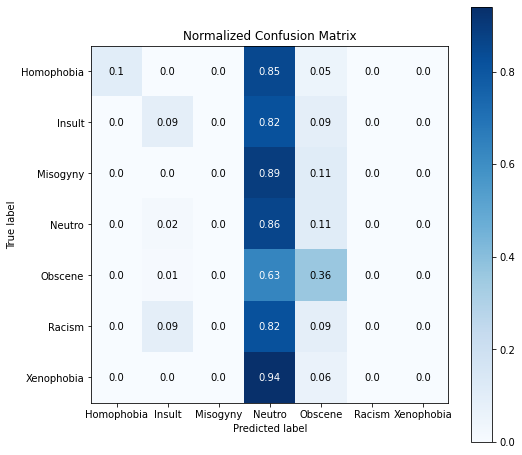

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_u, previsoes_u, normalize=True, figsize=(8, 8))

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_u, previsoes_u, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_u, previsoes_u)))

##Naive Bayes Classifier - Undersampling

In [ ]:
modelo_multi_NB_U = MultinomialNB()
modelo_multi_NB_U.fit(X_treinamento_u, y_treinamento_u)
prediction_NB_U = modelo_multi_NB_U.predict(X_teste_u)
accuracy_score(prediction_NB_U, y_teste_u)

0.06188247529901196

Relatório de Classificação:
               precision    recall  f1-score   support

  Homophobia     0.0110    0.1463    0.0205        41
      Insult     0.1601    0.0897    0.1150       546
    Misogyny     0.0031    0.1053    0.0060        19
      Neutro     0.6739    0.0421    0.0793      2208
     Obscene     0.2500    0.0817    0.1231      1004
      Racism     0.0024    0.3636    0.0048        11
  Xenophobia     0.0090    0.1176    0.0167        17

    accuracy                         0.0619      3846
   macro avg     0.1585    0.1352    0.0522      3846
weighted avg     0.4751    0.0619    0.0943      3846

Acurácia: 0.0619



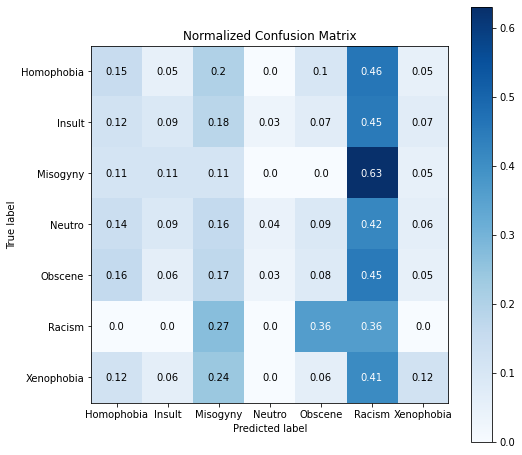

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_u, prediction_NB_U, normalize=True, figsize=(8, 8))

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_u, prediction_NB_U, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_u, prediction_NB_U)))

##Support Vector Machine (SVM) - Undersampling

In [ ]:
modelo_SVC_U = SVC()
modelo_SVC_U.fit(X_treinamento_u, y_treinamento_u)

prediction_SVC_U = modelo_SVC_U.predict(X_teste_u)
accuracy_score(prediction_SVC_U, y_teste_u)

0.5741029641185648

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Relatório de Classificação:
               precision    recall  f1-score   support

  Homophobia     0.0000    0.0000    0.0000        41
      Insult     0.0000    0.0000    0.0000       546
    Misogyny     0.0000    0.0000    0.0000        19
      Neutro     0.5741    1.0000    0.7294      2208
     Obscene     0.0000    0.0000    0.0000      1004
      Racism     0.0000    0.0000    0.0000        11
  Xenophobia     0.0000    0.0000    0.0000        17

    accuracy                         0.5741      3846
   macro avg     0.0820    0.1429    0.1042      3846
weighted avg     0.3296    0.5741    0.4188      3846

Acurácia: 0.5741



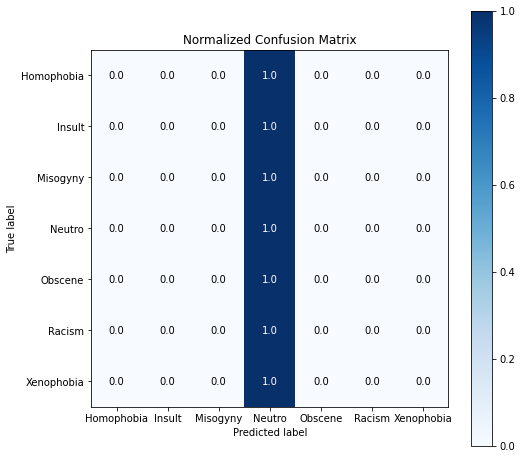

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_u, prediction_SVC_U, normalize=True, figsize=(8, 8))

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_u, prediction_SVC_U, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_u, prediction_SVC_U)))

##Logistic Regression - Undersampling

In [ ]:
modelo_RL_U = LogisticRegression()
modelo_RL_U.fit(X_treinamento_u, y_treinamento_u)

prediction_RL_U = modelo_RL_U.predict(X_teste_u)
accuracy_score(prediction_RL_U, y_teste_u)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.5717628705148206

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Relatório de Classificação:
               precision    recall  f1-score   support

  Homophobia     0.0000    0.0000    0.0000        41
      Insult     0.1818    0.0037    0.0072       546
    Misogyny     0.0000    0.0000    0.0000        19
      Neutro     0.5747    0.9950    0.7286      2208
     Obscene     0.0000    0.0000    0.0000      1004
      Racism     0.0000    0.0000    0.0000        11
  Xenophobia     0.0000    0.0000    0.0000        17

    accuracy                         0.5718      3846
   macro avg     0.1081    0.1427    0.1051      3846
weighted avg     0.3557    0.5718    0.4193      3846

Acurácia: 0.5718



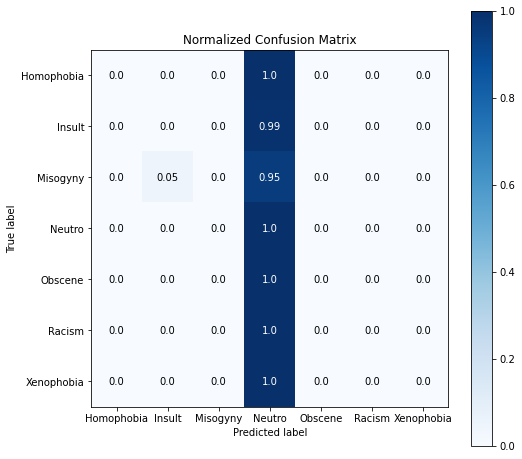

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_u, prediction_RL_U, normalize=True, figsize=(8, 8))

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_u, prediction_RL_U, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_u, prediction_RL_U)))

##Gradient Boosting - Undersampling

In [ ]:
modelo_GB_U = GradientBoostingClassifier()
modelo_GB_U.fit(X_treinamento_u, y_treinamento_u)

previsoes_GB_U = modelo_GB_U.predict(X_teste_u)
accuracy_score(previsoes_GB_U, y_teste_u)

0.608944357774311

Relatório de Classificação:
               precision    recall  f1-score   support

  Homophobia     0.3214    0.2195    0.2609        41
      Insult     0.5455    0.0110    0.0215       546
    Misogyny     0.0000    0.0000    0.0000        19
      Neutro     0.6206    0.9031    0.7357      2208
     Obscene     0.5943    0.3297    0.4241      1004
      Racism     0.0000    0.0000    0.0000        11
  Xenophobia     0.0909    0.1176    0.1026        17

    accuracy                         0.6089      3846
   macro avg     0.3104    0.2258    0.2207      3846
weighted avg     0.5927    0.6089    0.5393      3846

Acurácia: 0.6089



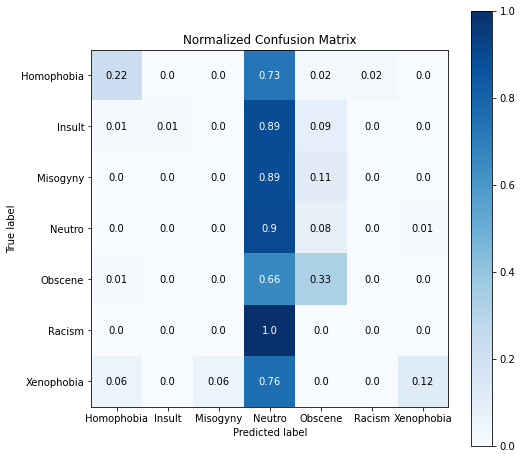

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_u, previsoes_GB_U, normalize=True, figsize=(8, 8))

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_u, previsoes_GB_U, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_u, previsoes_GB_U)))

##oversampling

##Sobreamostragem (oversampling) - SMOTE


In [ ]:
Xz = X
yz = y

In [ ]:
len(Xz)

21000

Class=1, n=12812 (14.286%)
Class=4, n=12812 (14.286%)
Class=3, n=12812 (14.286%)
Class=6, n=12812 (14.286%)
Class=5, n=12812 (14.286%)
Class=0, n=12812 (14.286%)
Class=2, n=12812 (14.286%)


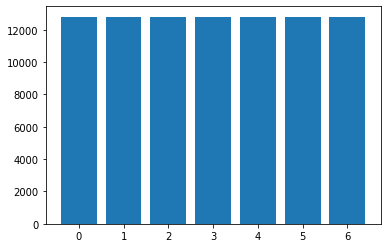

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# Encode do label
label_encode = LabelEncoder()
yz = label_encode.fit_transform(labels)

# transform the dataset
oversample = SMOTE()
X_overr, y_overr = oversample.fit_resample(Xz, yz)

# summarize distribution
counter = Counter(y_overr)
for k,v in counter.items():
	per = v / len(y_overr) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
X_overr.shape, y_overr.shape

((89684, 50), (89684,))

In [ ]:
np.unique(labels, return_counts=True)

(array(['Homophobia', 'Insult', 'Misogyny', 'Neutro', 'Obscene', 'Racism',
        'Xenophobia'], dtype='<U10'),
 array([  207,  2730,    95, 12812,  5017,    54,    85]))

In [ ]:
np.unique(y_overr, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([12812, 12812, 12812, 12812, 12812, 12812, 12812]))

In [ ]:
X_treinamento_oo, X_teste_oo, y_treinamento_oo, y_teste_oo = train_test_split(X_overr, y_overr, 
                                                                          test_size = 0.2, stratify = y_overr)
X_treinamento_oo.shape, X_teste_oo.shape

((71747, 50), (17937, 50))

##Random Forest - Oversampling

In [ ]:
modelo_o = RandomForestClassifier()
modelo_o.fit(X_treinamento_oo, y_treinamento_oo)
previsoes_o = modelo_o.predict(X_teste_oo)
accuracy_score(previsoes_o, y_teste_oo)

0.8689858950772147

- 86%

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9380    0.9750    0.9562      2562
           1     0.7716    0.8189    0.7945      2562
           2     0.9735    0.9902    0.9818      2562
           3     0.6933    0.5724    0.6271      2563
           4     0.7351    0.7581    0.7464      2563
           5     0.9792    0.9910    0.9851      2563
           6     0.9646    0.9774    0.9709      2562

    accuracy                         0.8690     17937
   macro avg     0.8651    0.8690    0.8660     17937
weighted avg     0.8650    0.8690    0.8660     17937

Acurácia: 0.8690



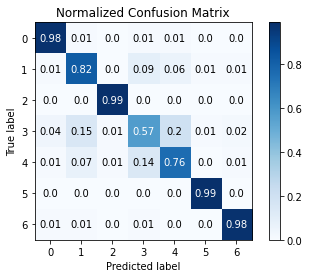

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_o, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_o, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_o)))

##Naive Bayes Classifier - Oversampling

In [ ]:
modelo_multi_NB_O = MultinomialNB()
modelo_multi_NB_O.fit(X_treinamento_oo, y_treinamento_oo)

previsoes_NB_O = modelo_multi_NB_O.predict(X_teste_oo)
accuracy_score(previsoes_NB_O, y_teste_oo)

0.18955232201594469

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.1632    0.2393    0.1941      2562
           1     0.2308    0.0878    0.1272      2562
           2     0.1585    0.1831    0.1699      2562
           3     0.2680    0.0698    0.1108      2563
           4     0.1476    0.0398    0.0627      2563
           5     0.2001    0.5837    0.2980      2563
           6     0.2238    0.1233    0.1590      2562

    accuracy                         0.1896     17937
   macro avg     0.1989    0.1895    0.1602     17937
weighted avg     0.1989    0.1896    0.1602     17937

Acurácia: 0.1896



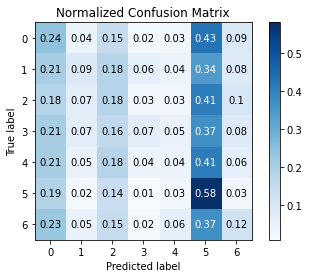

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_NB_O, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_NB_O, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_NB_O)))

##Support Vector Machine (SVM) - Oversampling

In [ ]:
modelo_SVC_O = SVC()
modelo_SVC_O.fit(X_treinamento_oo, y_treinamento_oo)

previsoes_SVC_O = modelo_SVC_O.predict(X_teste_oo)
accuracy_score(previsoes_SVC_O, y_teste_oo)

0.4741038077716452

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.4534    0.4536    0.4535      2562
           1     0.6154    0.3048    0.4077      2562
           2     0.6185    0.5347    0.5736      2562
           3     0.6244    0.1959    0.2982      2563
           4     0.2686    0.4932    0.3478      2563
           5     0.4508    0.7788    0.5710      2563
           6     0.7321    0.5578    0.6331      2562

    accuracy                         0.4741     17937
   macro avg     0.5376    0.4741    0.4693     17937
weighted avg     0.5376    0.4741    0.4693     17937

Acurácia: 0.4741



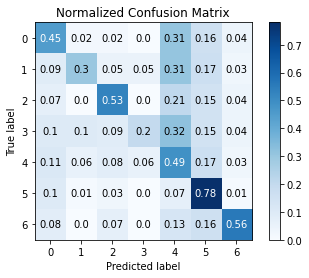

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_SVC_O, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_SVC_O, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_SVC_O)))

##Logistic Regression - Oversampling

In [ ]:
modelo_RL_O = LogisticRegression()
modelo_RL_O.fit(X_treinamento_oo, y_treinamento_oo)

previsoes_RL_O = modelo_RL_O.predict(X_teste_oo)
accuracy_score(previsoes_RL_O, y_teste_oo)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.21374811841445057

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.1843    0.1928    0.1884      2562
           1     0.2694    0.0827    0.1266      2562
           2     0.1753    0.2393    0.2023      2562
           3     0.2385    0.0792    0.1189      2563
           4     0.0000    0.0000    0.0000      2563
           5     0.2193    0.5919    0.3200      2563
           6     0.2484    0.3103    0.2759      2562

    accuracy                         0.2137     17937
   macro avg     0.1907    0.2137    0.1760     17937
weighted avg     0.1907    0.2137    0.1760     17937

Acurácia: 0.2137



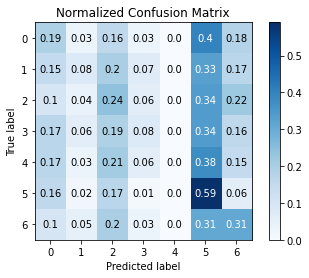

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_RL_O, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_RL_O, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_RL_O)))

##Gradient Boosting - Oversampling

In [ ]:
modelo_GB_O = GradientBoostingClassifier()
modelo_GB_O.fit(X_treinamento_oo, y_treinamento_oo)

previsoes_GB_O = modelo_GB_O.predict(X_teste_oo)
accuracy_score(previsoes_GB_O, y_teste_oo)

0.5601828622400624

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.5124    0.6526    0.5741      2562
           1     0.4810    0.2674    0.3437      2562
           2     0.6106    0.7553    0.6753      2562
           3     0.4812    0.2247    0.3064      2563
           4     0.4692    0.4721    0.4706      2563
           5     0.6174    0.8712    0.7227      2563
           6     0.6462    0.6780    0.6617      2562

    accuracy                         0.5602     17937
   macro avg     0.5454    0.5602    0.5363     17937
weighted avg     0.5454    0.5602    0.5363     17937

Acurácia: 0.5602



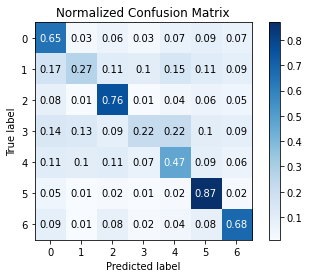

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_teste_oo, previsoes_GB_O, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_teste_oo, previsoes_GB_O, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_teste_oo, previsoes_GB_O)))

#Utilizando comentário diferente

In [ ]:
def teste(text1):

  train_examples_real = []

  tokens_text = [token.text for token in nlp(text1)]
  train_examples_real.append(tokens_text)
  sequences1 = tokenizer.texts_to_sequences(train_examples_real)

  MAX_LEN = 50
  #Agora X é uma lista de sequências de 50 palavras
  Xs = pad_sequences(sequences1, MAX_LEN, padding="post")

  #converteremos esta lista de comentários e os rótulos em matrizes numpy
  Xs = np.array(Xs)

  predictions = modelo_o.predict(Xs)

  # Retornando os labels
  predic_label = label_encode.inverse_transform(predictions)

  return predic_label

In [ ]:
teste("baiano é um preguiçoso")

array(['Insult'], dtype='<U10')